# Sky model tutorial

Followed from https://cosmoglobe.readthedocs.io/en/latest/tutorials/skymodel.html.

## Accessing the Cosmoglobe sky model

To access the Cosmoglobe sky model, we will use the `cosmoglobe.sky_model`function. This function initiatilizes the Cosmoglobe sky model at a requested `nside`.

In [1]:
import cosmoglobe
model = cosmoglobe.sky_model(nside=256)

Initializing model from cached chainfile


synch: 100%|█████████████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


## Inspecting the model

In [2]:
model

SkyModel(
  version: BeyondPlanck
  nside: 256
  components( 
    (ame): SpinningDust(freq_peak)
    (cmb): CMB()
    (dust): ModifiedBlackbody(beta, T)
    (ff): LinearOpticallyThin(T_e)
    (radio): AGNPowerLaw(alpha)
    (synch): PowerLaw(beta)
  )
)

## Model components

In [3]:
print(model.components["dust"])
print(model.components["synch"])

ModifiedBlackbody(beta, T)
PowerLaw(beta)


### Component attributes

The model data is stored in the following component attributes:

- `amp`: Amplitude map at the reference frequency.
- `freq_ref`: Reference frequency of `amp`.
- `spectral_parameters`: A dictionary containing the spectral parameters.

In [4]:
print(model.components["dust"].amp)
print(model.components["dust"].freq_ref)
print(model.components["dust"].spectral_parameters)

[[12.79380393 16.83398351 12.47737776 ... 16.43026688 15.43511106
  14.71825645]
 [-2.17450405 -4.46803828 -0.95729435 ...  3.93594893 -5.55828957
   1.46470534]
 [-1.26519173  1.54428605  1.61832597 ... -0.18325869  2.85220057
  -4.31594049]] uK_RJ
[[857.]
 [353.]
 [353.]] GHz
{'beta': <Quantity [[1.5599756],
           [1.6233921],
           [1.6233921]]>, 'T': <Quantity [[11.439933, 11.945269, 11.979894, ..., 17.054482, 17.034973,
            16.92691 ],
           [11.439933, 11.945269, 11.979894, ..., 17.054482, 17.034973,
            16.92691 ],
           [11.439933, 11.945269, 11.979894, ..., 17.054482, 17.034973,
            16.92691 ]] K>}


### Visualizing components

We can use `cosmoglobe.plot`, which is a wrapper on healpy's mollview function.

In [5]:
from cosmoglobe import plot
from healpy import mollview
%matplotlib inline
path = "/mn/stornext/d5/data/aimartin/tutorials/sky-model/output"

In [6]:
# Stokes Q map of dust
dust_amp_Q = model.components["dust"].amp[1]
mollview(
    dust_amp_Q,
    title="Dust Stokes Q",
    norm="hist"
)

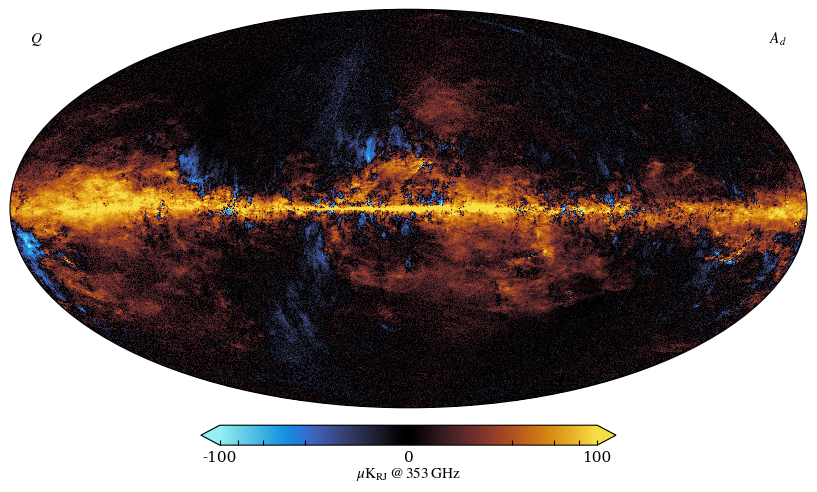

In [7]:
# Pass in the model and specify which component to plot
plot(model, comp="dust", sig="Q")

## Simulations

### Simulating component emission

We can simulate the emission from a component at an arbitrary frequency `freq` by calling the component's `__call__` method, e.g. `model.dust(freq)`.

This function takes in the following key word arguments:
- `freqs`: A frequency, or a list of frequencies for which to evaluate the sky emission.
- `bandpass`: Bandpass profile corresponding to the frequencies (*optional*).
- `fwhm`: The full width at half maximum parameter of the Gaussian used to smooth the output (*optional*).
- `output_unit`: The output units of the emission. By default the output unit of the model is always in uK_RJ.

Simulation of synchrotron emission (electromagnetic radiation emitted when relativistically charged particles are subject to an acceleration perpendicular to their velocity) at 20 GHz:

In [8]:
import astropy.units as u # astropy.units is a package for unit handling

# Simulated synchrotron emission at 20GHz
simulated_emission = model(20*u.GHz, components=["synch"])

plot(
    simulated_emission[0],
    title="Synchrotron simulated at 20GHz",
    cmap="swamp"
)

Simulation of free-free emission (electromagnetic radiation produced by the deceleration of a charged particle when deflected by another charged particle, typically an electron by an atomic nucleus) at 60 GHz with a FWHM of 30' and output units set to MJy/sr:

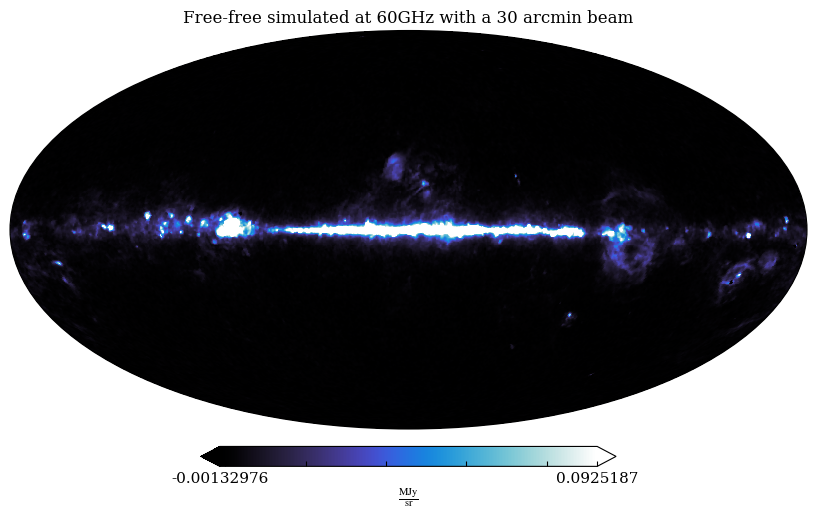

In [9]:
# Simulated free-free emission at 60 GHz seen by a 30 arcmin beam in units of MJy/sr
simulated_emission = model(
    60*u.GHz,
    fwhm=30*u.arcmin,
    output_unit="MJy/sr",
    components=["ff"]
)

plot(
    simulated_emission[0],
    title="Free-free simulated at 60GHz with a 30 arcmin beam",
    unit=simulated_emission.unit,
    cmap="freeze",
)

### Simulating model emission

We can simulated the sky emission over the full model at a given frequency:

In [10]:
# Simulated full sky emission at 100 GHz seen by a 60 arcmin beam (the instrument's sensitivity pattern is such that it can distinguish sources that are at least 60 arcminutes apart) in units of uK_RJ
simulated_emission = model(100*u.GHz, fwhm=60*u.arcmin)

plot(
    simulated_emission[0],
    title="Full sky simulated at 100 GHz with a 60 arcmin beam",
    min=-3400,
    max=3400
)

We can remove the solar dipole (temperature anisotropy caused by the motion of the Sun):

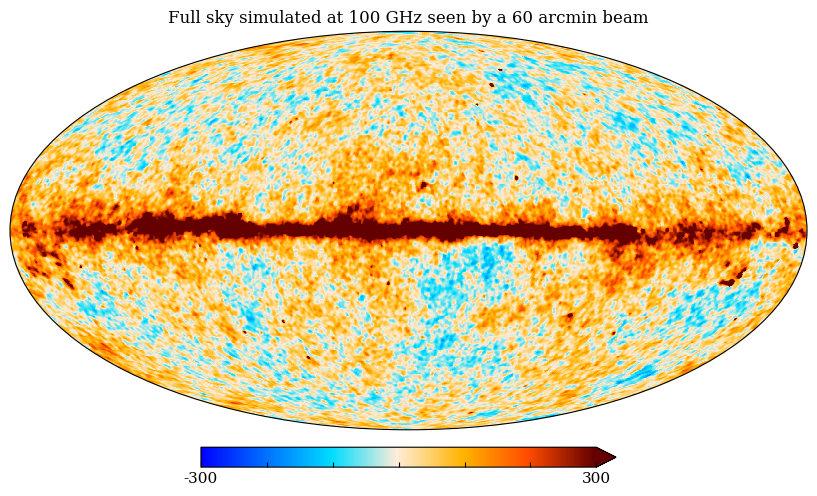

In [11]:
# Remove the solar dipole
model.remove_dipole()

# Simulated full sky emission at 100 GHz seen by a 60 arcmin beam in units of uK_RJ
simulated_emission = model(100*u.GHz, fwhm=60*u.arcmin)

plot(
    simulated_emission[0],
    title="Full sky simulated at 100 GHz seen by a 60 arcmin beam",
    min=-300,
    max=300,
)

### Bandpass integration

We can make simulations that have integrated the sky emission over a given bandpass. If only a list of frequencies are supplied without an explicit bandpass input, a top-hat bandpass (high in the bandpass and zero everywhere else) will be used during the integratin.

In [12]:
import numpy as np

frequencies = np.arange(100, 110, 50) * u.GHz
print(frequencies)

[100.] GHz


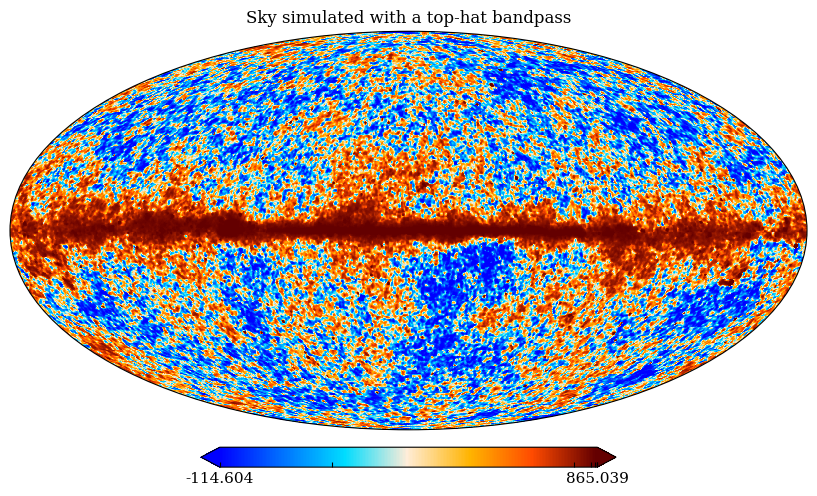

In [13]:
simulated_emission = model(frequencies, fwhm=40 * u.arcmin)

plot(
    simulated_emission[0],
    title="Sky simulated with a top-hat bandpass",
    norm="hist"
    )

To load a different type of a bandpass profile use `frequencies, bandpass, _ = np.loadtxt(bandpass_path, unpack=True)`. For example, a WMAP K-band (frequencies 18-27 GHz) bandpass profile.

It's important to give the bandpass unit (even if it is normalized) to differentiate bandpasses measured in $K_{CMB}$ and $K_{RJ}$ units, by using e.g. `frequencies *= u.GHz` and `bandpass *= u.Unit("K_RJ")`.

## Point sources

The radio component does not store HEALPIX amplitude maps internally. Instead, the *amp* quantity contains a list of amplitude values, one per point source. Each source is then mapped to a HEALPIX map with a truncated gaussian beam whenever the model (or radio component) is called.

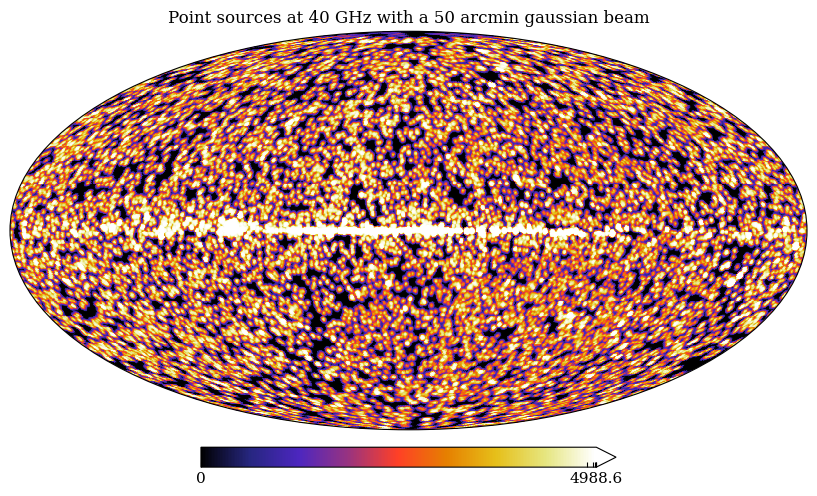

In [16]:
# Point sources seen at 40GHz over a 50 arcmin gaussian beam
simulated_emission = model(40*u.GHz, fwhm=59*u.arcmin, components=["radio"])

plot(
    simulated_emission[0],
    title="Point sources at 40 GHz with a 50 arcmin gaussian beam",
    norm="hist",
    cmap="CMRmap"
)

## Plotting

Similar to available potting scripts such as healpy's `mollview`, `plot` allows for direct plotting of map-arrays. However, it also supports direct plotting of cosmoglobe model objects and direct reading of fit files.

Another defininf feature of the code is the automatic parameter setting defined specifically for each sky component, set by speciying the `comp` input.

Other useful features include direct smoothing, ud_grading, and mono-dipole removel of the passed maps.

Examples:

In [17]:
plot(model, freq=30*u.GHz, sig="Q")

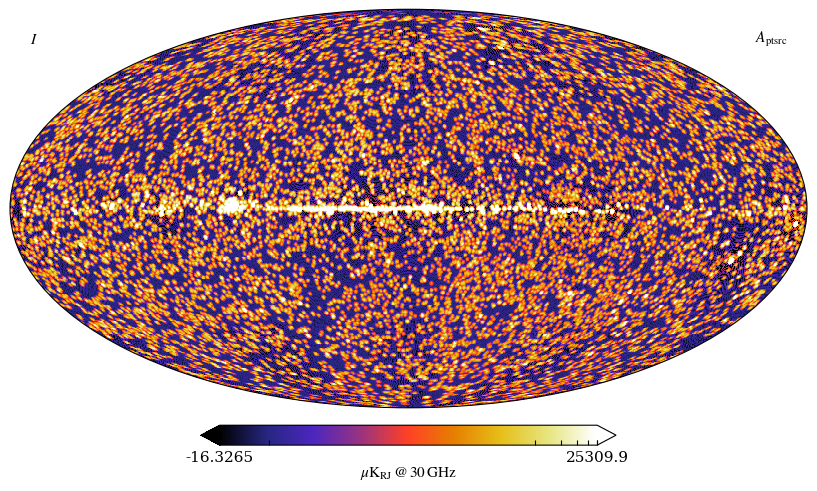

In [18]:
plot(model, comp="radio", fwhm=30*u.arcmin)

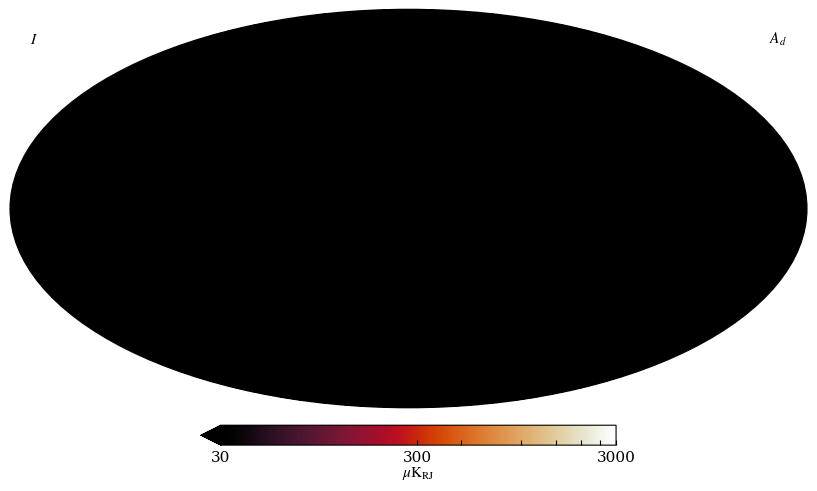

In [20]:
fits_filename = "/mn/stornext/d5/data/aimartin/tutorials/healpy/data/wmap_temperature_analysis_mask_r9_7yr_v4.fits"
plot(fits_filename, comp="dust")